In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as npimg
import os

## Keras
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense

import cv2
import pandas as pd
import random
import ntpath

## Sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [12]:
## Store data
datadir = 'Self-Driving-Car'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names = columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_382.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_526.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_669.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_802.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,C:\Users\Win 10\Desktop\benign\IMG\center_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\left_2019_07_22_20_38_15_937.jpg,C:\Users\Win 10\Desktop\benign\IMG\right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


In [13]:
def path_leaf(path):
  """Get tail of path"""
  head, tail = ntpath.split(path)
  return tail

## Remove path of images
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_07_22_20_38_15_382.jpg,left_2019_07_22_20_38_15_382.jpg,right_2019_07_22_20_38_15_382.jpg,0.0,0.0,0,0.000079
1,center_2019_07_22_20_38_15_526.jpg,left_2019_07_22_20_38_15_526.jpg,right_2019_07_22_20_38_15_526.jpg,0.0,0.0,0,0.000082
2,center_2019_07_22_20_38_15_669.jpg,left_2019_07_22_20_38_15_669.jpg,right_2019_07_22_20_38_15_669.jpg,0.0,0.0,0,0.000078
3,center_2019_07_22_20_38_15_802.jpg,left_2019_07_22_20_38_15_802.jpg,right_2019_07_22_20_38_15_802.jpg,0.0,0.0,0,0.000078
4,center_2019_07_22_20_38_15_937.jpg,left_2019_07_22_20_38_15_937.jpg,right_2019_07_22_20_38_15_937.jpg,0.0,0.0,0,0.000080


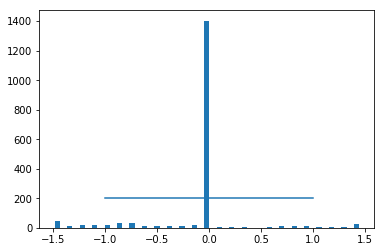

In [14]:
## Visualize data
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5  # center the bins to 0

## Plot
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Total data: 1743
Removed: 1203
Remaining: 540


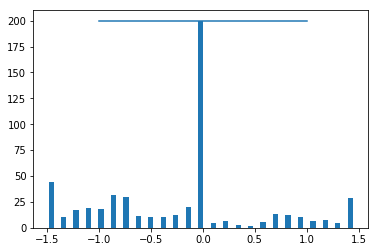

In [15]:
print('Total data: {0}'.format(len(data)))

## Make list of indices to remove
remove_list = []
for j in range(num_bins):
  list_ = []
  for i in range(len(data['steering'])):
    steering_angle = data['steering'][i]
    if steering_angle >= bins[j] and steering_angle <= bins[j+1]:
      list_.append(i)
  list_ = shuffle(list_)
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)
  
## Remove from extras from list
data.drop(data.index[remove_list], inplace=True)
print('Removed: {0}'.format(len(remove_list)))
print('Remaining: {0}'.format(len(data)))

## Plot
hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [ ]:
def load_img_steering(datadir, df):
  """Get img and steering data into arrays"""
  image_path = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

Training Samples: 432
Valid Samples: 108


Text(0.5, 1.0, 'Validation set')

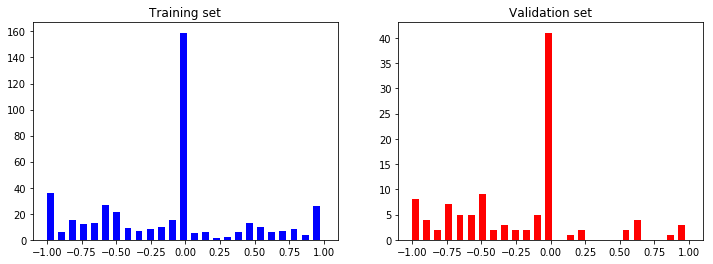

In [17]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=0)

## Check that data is valid
print("Training Samples: {}\nValid Samples: {}".format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(Y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(Y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [ ]:
def img_preprocess(img):
  """Take in path of img, returns preprocessed image"""
  img = npimg.imread(img)
  
  ## Crop image to remove unnecessary features
  img = img[60:135, :, :]
  
  ## Change to YUV image
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  
  ## Gaussian blur
  img = cv2.GaussianBlur(img, (3, 3), 0)
  
  ## Decrease size for easier processing
  img = cv2.resize(img, (100, 100))
  
  ## Normalize values
  img = img / 255
  return img

Text(0.5, 1.0, 'Preprocessed Image')

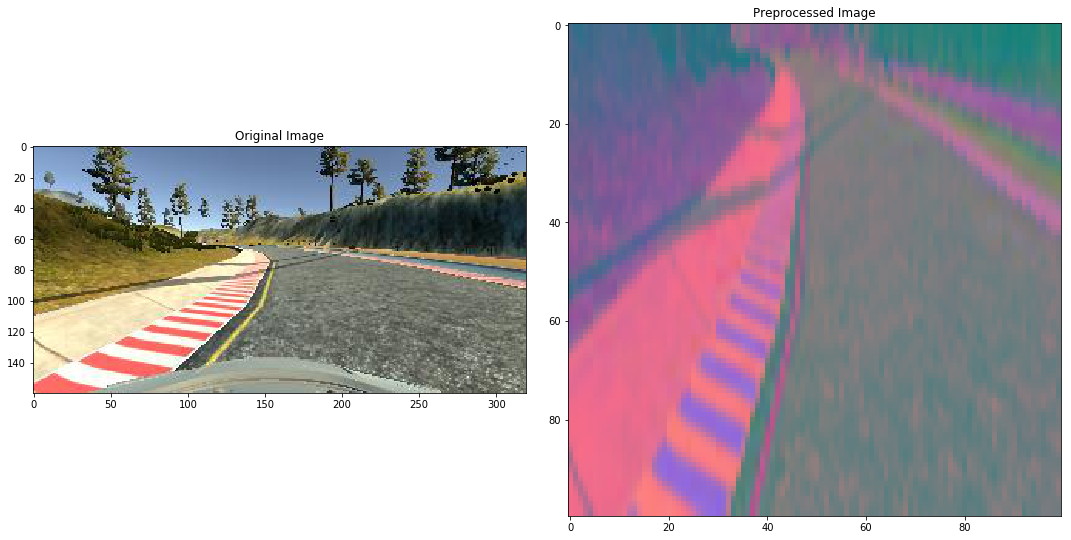

In [19]:
## Get any image
image = image_paths[100]
original_image = npimg.imread(image)
preprocessed_image = img_preprocess(image)

## Compare original and preprocessed image
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')

In [ ]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_valid = np.array(list(map(img_preprocess, X_valid)))

(432, 100, 100, 3)


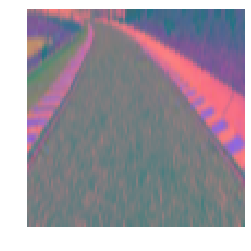

In [21]:
plt.imshow(X_train[random.randint(0, len(X_train)-1)])
plt.axis('off')
print(X_train.shape)

In [22]:
from keras.applications import ResNet50
#Load the ResNet50 model
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

W0825 19:23:58.183147 139742454921088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 19:23:58.220489 139742454921088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 19:23:58.230545 139742454921088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0825 19:23:58.262837 139742454921088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0825 19:23:58.263474

    8192/94653016 [..............................] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [23]:
# Freeze the layers except the last 4 layers
for layer in resnet.layers[:-4]:
    layer.trainable = False
 
for layer in resnet.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f17f5711400> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f17f4d9fda0> False
<keras.layers.convolutional.Conv2D object at 0x7f17f4d9f8d0> False
<keras.layers.normalization.BatchNormalization object at 0x7f17f4d30cc0> False
<keras.layers.core.Activation object at 0x7f17f4d3aba8> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f17f34c85c0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f17e438dc18> False
<keras.layers.convolutional.Conv2D object at 0x7f17f34f4400> False
<keras.layers.normalization.BatchNormalization object at 0x7f17e43821d0> False
<keras.layers.core.Activation object at 0x7f17e4382da0> False
<keras.layers.convolutional.Conv2D object at 0x7f17e4382e10> False
<keras.layers.normalization.BatchNormalization object at 0x7f17e4342860> False
<keras.layers.core.Activation object at 0x7f17e4300f28> False
<keras.layers.convolutional.Conv2D object at 0x7f17e41e05c0> False
<keras.layers.convolution

In [ ]:
def nvidia_model():
  model = Sequential()
  model.add(resnet)

  model.add(Dropout(0.5))
  
  model.add(Flatten())
  
  model.add(Dense(100, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(10, activation='elu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(1))
  
  optimizer = Adam(lr=1e-3)
  model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
  return model

In [25]:
model = nvidia_model()
print(model.summary())

W0825 19:24:11.704631 139742454921088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0825 19:24:11.817271 139742454921088 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 4, 4, 2048)        23587712  
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 2048)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3276900   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
__________

In [26]:
history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_valid, Y_valid), batch_size=128, verbose=1, shuffle=1)

Train on 432 samples, validate on 108 samples
Epoch 1/25
432/432 [==============================] - 1s 1ms/step - loss: 1.4304 - acc: 0.1597 - val_loss: 0.4176 - val_acc: 0.3796
Epoch 21/25
432/432 [==============================] - 1s 1ms/step - loss: 1.8383 - acc: 0.1736 - val_loss: 0.4077 - val_acc: 0.3796
Epoch 22/25
432/432 [==============================] - 1s 1ms/step - loss: 1.3433 - acc: 0.1620 - val_loss: 0.3917 - val_acc: 0.3796
Epoch 23/25
432/432 [==============================] - 1s 1ms/step - loss: 1.3764 - acc: 0.1551 - val_loss: 0.3795 - val_acc: 0.3796
Epoch 24/25
432/432 [==============================] - 1s 1ms/step - loss: 1.2427 - acc: 0.1435 - val_loss: 0.3730 - val_acc: 0.3796
Epoch 25/25
432/432 [==============================] - 1s 1ms/step - loss: 1.3871 - acc: 0.1875 - val_loss: 0.3651 - val_acc: 0.3796


Text(0.5, 0, 'Epoch')

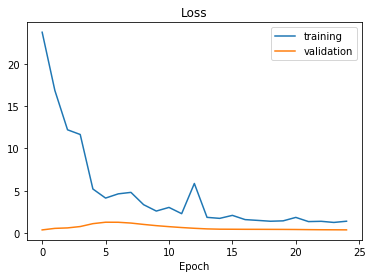

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [ ]:
model.save(r'model/model.h5')